In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Parameters for pipeline 
# num_split = 5
# num_repeat = 10
# s_list = [0,1]
# alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))
# l_list = [3, 6]

with open('repeated_kfold_wd_shift_round01.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

l = 6

**Update 12/Nov/2020**: run repeated kfold for round 0+1 results, using partial replicates in ['../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'] with kernel normalisation, recorded in [repeated_kfold_wd_shift_round01.pickle]
add another evaluation metirc converate rate, which is the percent of true labels inside of 95% prediced confidence interval. We also tested different values for sigma_0 (signal std in [this guide](https://drafts.distill.pub/gp/#gp-noise))
- num_split = 5
- num_repeat = 5
- s_list = [0,1]
- alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
- l_list =[3,6]
- sigma_0_list = [0.5, 1, 2]

**Update**: run repeated kfold for round 0 + round 1 results ['../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'] without kernel normalisation, recorded in [repeated_kfold_wd_shift_round01_without_kernelNorm.pickle].   
Parameters: 
- num_split = 5
- num_repeat = 5
- s_list = [0,1]
- alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
- l_list =[3,4,5,6]
- sigma_0_list = [1]

use xarray to store results
dimensions:

- train_test: results for train(0) or test(1) 
- eva_on: evaluate on sample labels(0) or average(1)
- eva_metric: mean square error(0) or r2 score(1)
- alpha (parameter of GPR, which adds to the diagonal of kernel matrix)
- l (length of kmer)
- s (shift length)
- repeat (nth repeat)
- fold (k-fold)

## Train performance

Report performance in terms the average score of repeats and folds.  
Visualisation can only do for two dimensions, so separate s = 0 and s = 1.

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the higer the better); Second col: eva_metric = R2 (the lower the better); Third col: coverage rate (the higher the better)

x, y axis:  
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5]   
sigma_0 = [0.5,1,2]

In [3]:
ave_train_result = result_pkl[0].mean(axis = -1).mean(axis = -1)

s = 0, i.e. wd kernel.

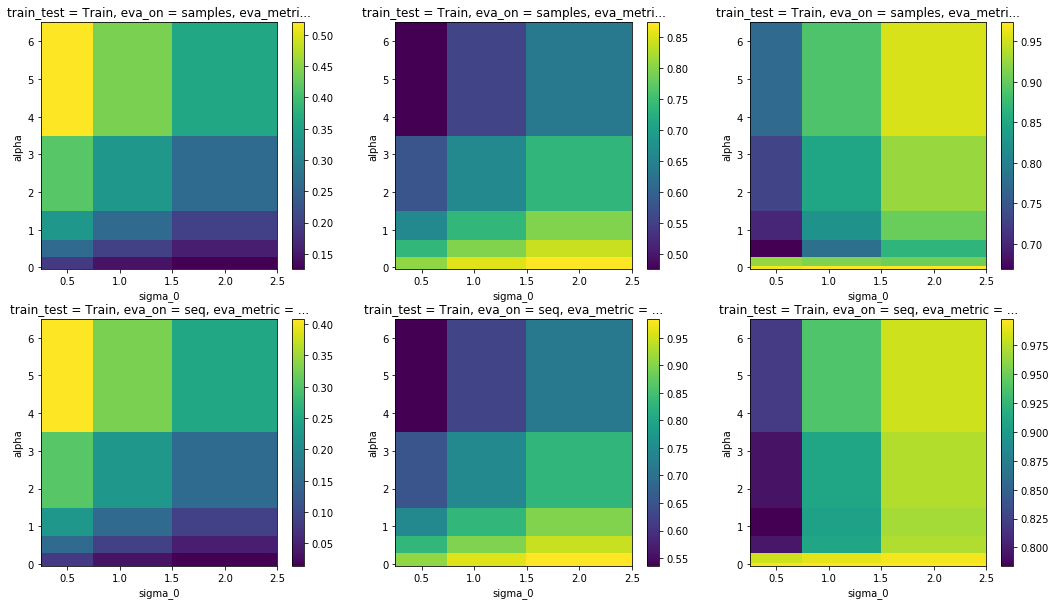

In [4]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_train_result[i][j].loc[dict(s = 0)].loc[dict(l=l)].plot(ax=a[i][j])

s = 1, i.e. wd kernel with 1 shift

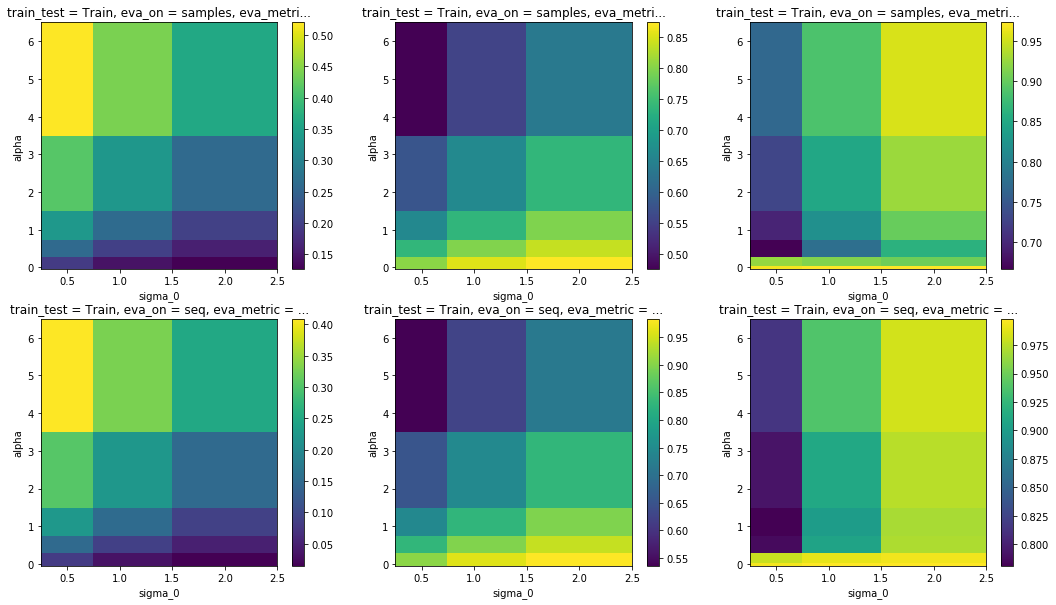

In [5]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_train_result[i][j].loc[dict(s = 1)].loc[dict(l=l)].plot(ax=a[i][j])

Summary: for training
- s = 0 or 1 almost does not influence the performance.
- for both eva metric, the LOWER the alpha, and when l = 6, the performance is better.
- for both eva on samples or averages, the trend is the same, while the value is different (seq has a smaller MSE, bigger R2). So the choice of best parameter does not be influenced by the eva_on.

## Test performance

Report performance in terms the average score of repeats and folds.  
Visualisation can only do for two dimensions, so separate s = 0 and s = 1.

First row: eva_on = samples; Second row: eva_on = seqs  
First col: eva_metric = MSE (the higer the better); Second col: eva_metric = R2 (the lower the better)

x, y axis:  
alpha_list= [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + list(range(1,11))  
l_list = [3, 6]

In [6]:
ave_test_result = result_pkl[1].mean(axis = -1).mean(axis = -1)

s = 0, i.e. wd kernel.

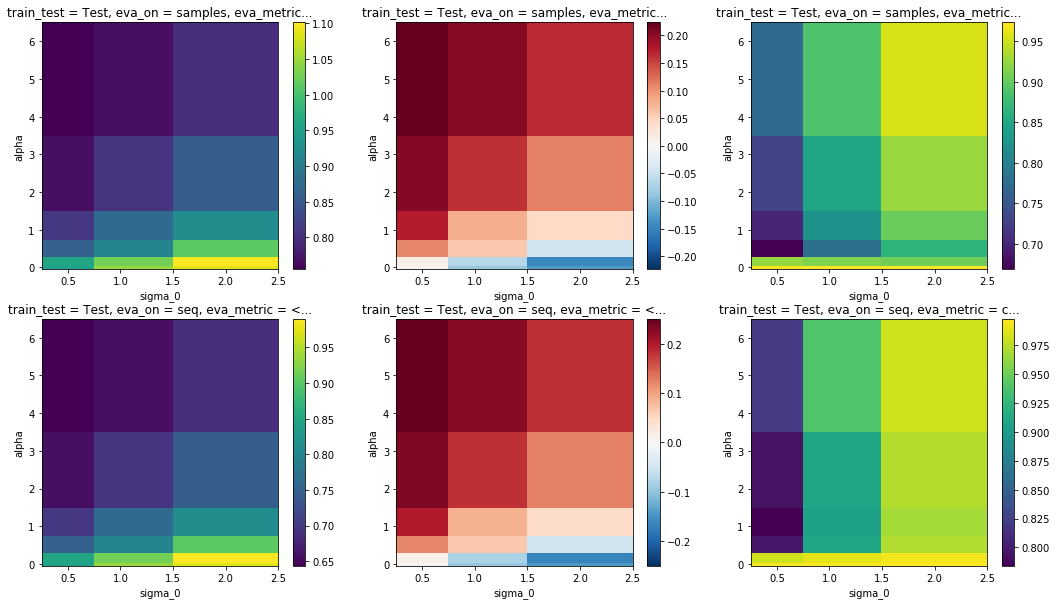

In [7]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_test_result[i][j].loc[dict(s = 0)].loc[dict(l=l)].plot(ax=a[i][j])

s = 1, i.e. wd kernel with 1 shift

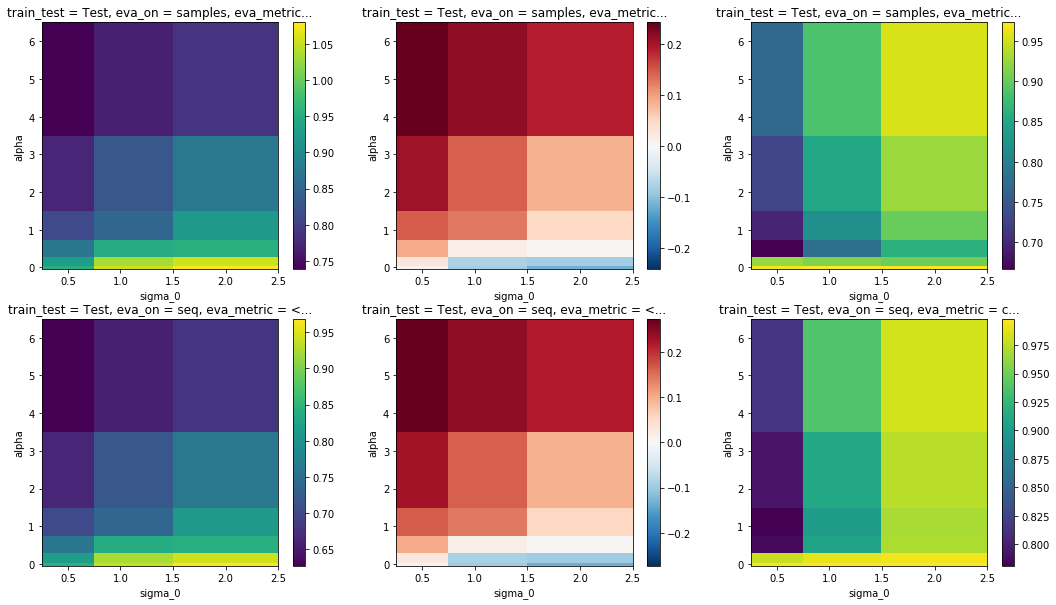

In [8]:
num_rows = 2
num_cols = 3

fig,a = plt.subplots(num_rows, num_cols, figsize = (18,10))

for i in range(num_rows):
    for j in range(num_cols):
        ave_test_result[i][j].loc[dict(s = 1)].loc[dict(l=l)].plot(ax=a[i][j])

Summary: for testing
- s still does not influence too much. But when l=3, s = 0 does better; l=6, s = 1 does better for smaller alphas.
- for both eva metric, the HIGHER the alpha, and when l = 6, the performance is better.
- for both eva on samples or averages, the trend is the same, while the value is different (seq has a smaller MSE, similar R2). So the choice of best parameter does not be influenced by the eva_on.

## Select parameters and show performance

based on above results, we choose

- l = 6
- alpha = 0,2,5
- s = 1
- sigma_0 = 2

In [9]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Unnamed: 16,Rep7,Rep8,Rep9,RBS6,index,Pred Mean,Pred Std,Pred UCB
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.433056,2.502155,2.315237,3.012905,2.917124,2.275329,2.575968,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.556251,1.654243,1.762146,1.790123,2.312790,1.959275,1.839138,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.603551,0.748674,0.921939,0.391285,0.503846,0.711231,0.646754,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.658359,1.874275,1.534988,1.546110,1.747116,1.232548,1.598899,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.545942,2.072095,1.386300,1.949759,1.774833,2.146898,1.812638,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN


X train shape:  (1079, 20)
X test shape:  (53, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f16ff3b3488>
Train:  0.1560600596787125
Test:  0.6347318854854098
<function r2_score at 0x7f16ff3b36a8>
Train:  0.8245968976464373
Test:  0.2137175804663225


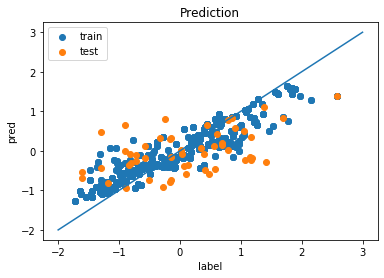

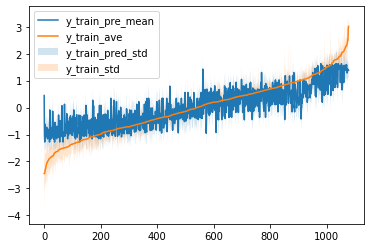

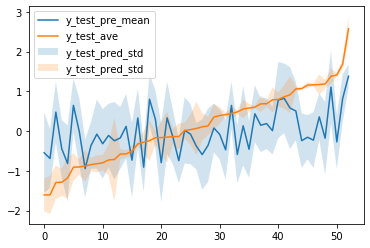

In [10]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 2, eva_on='seqs', sigma_0=2)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()
gpr_train_samples.line_plot()

(array([ 1.,  0.,  0.,  2., 11., 12.,  8.,  6.,  7.,  6.]),
 array([0.28690114, 0.3613922 , 0.43588326, 0.51037432, 0.58486538,
        0.65935644, 0.7338475 , 0.80833856, 0.88282962, 0.95732067,
        1.03181173]),
 <a list of 10 Patch objects>)

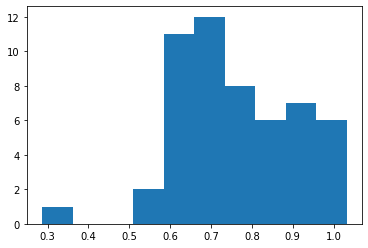

In [11]:
plt.hist(gpr_train_samples.test_df['pred std'])

# Sort kernel matrix?

Using the code in result_analysis/kernel_matrix_analysis.ipynb

In [12]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def sort_kernel_matrix(df):
    group_dict = df.groupby('Group').groups
    groups = list(group_dict.keys())
    print('groups: ', groups)
    new_ordering = [] # idx ordering
    kmeans_based_on = 'label_distance'

    frr_seqs = np.asarray(df['RBS'])

    for group in groups:
        df_group = df[df['Group'] == group]
        num_seqs = len(df_group)
        num_clusters = int(num_seqs/4) + 1
        print('Group: ', group)
        print('Number of sequences: ', num_seqs)
        print('number of clusters: ', num_clusters)
        
        idx = np.asarray(group_dict[group])
        # print('idx: ', idx)
        #print(label_distance[idx[0]: idx[-1], idx[0]: idx[-1]])
        
        
        if kmeans_based_on == 'label_distance': # kmeans based on label distances
            kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(np.asarray(df['AVERAGE'])[idx].reshape(len(idx),1))
            cluster_dict = defaultdict(list) # key: cluster id; value: idx list
            for i, cluster_id in enumerate(kmeans.labels_):
                cluster_dict[cluster_id].append(idx[i])
            # print('cluster dict: ', cluster_dict)
            # print('kmeans labels: ', kmeans.labels_)
            
        elif kmeans_based_on == 'spec_distance': # kmeans based on spectrum distances 
            #kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(phi_X[idx[0]: idx[-1] + 1, :])
            model = AgglomerativeClustering(n_clusters=num_clusters)
            model.fit(phi_X[idx[0]: idx[-1] + 1, :])
            cluster_dict = defaultdict(list) # key: cluster id; value: idx list
            for i, cluster_id in enumerate(model.labels_):
                cluster_dict[cluster_id].append(idx[i])
            # print('cluster dict: ', cluster_dict)
            # print('kmeans labels: ', model.labels_)

        # print('Sorting inside clusterings:')
        for key, value in cluster_dict.items():
            seq_list = []
            for i in value:
                seq_list.append(frr_seqs[i])
            # print('key: ', key)
            # print('seq list: ', seq_list)
            
            argsorted_seq_list = np.argsort(seq_list)
            # print('argsorted seq list: ', argsorted_seq_list)
            
            cluster_dict[key] = np.asarray(value)[np.asarray(argsorted_seq_list)]
        # print('sorted cluster dict: ', cluster_dict)
        
        # print('Sorting clusterings:')
        
        
        if kmeans_based_on == 'label_distance':
            # print('kmeans cluster center: ', kmeans.cluster_centers_)
            argsorted_cluster_ids = np.argsort(kmeans.cluster_centers_.reshape(num_clusters,))[::-1]
        else:
            # TODO: check
            argsorted_cluster_ids = range(num_clusters)
            
        # print('argsort kmeans cluster center: ', argsorted_cluster_ids)
        for cluster_id in argsorted_cluster_ids:
            for i in cluster_dict[cluster_id]:   
                new_ordering.append(i)
                
        # print('new ordering: ', new_ordering)
        # print()              

    return new_ordering                                        

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def generate_plot(df, title = 'Train Data Similarity and Prediction'):
    new_kernel = WD_Shift_Kernel
    new_kernel.INIT_FLAG = False
    feature_kernel = new_kernel(l=6, features = np.asarray(df['RBS'])).kernel_all_normalised
    
    # sort 
    order = np.asarray(sort_kernel_matrix(df))
    feature_kernel = feature_kernel[:, order][order,:]

    f, ax = plt.subplots(figsize=(10,12))

    # t = np.linspace(0, 31.3, 100)
    # f = np.linspace(0, 1000, 1000)
    # a = np.exp(-np.abs(f-200)/200)[:, None] * np.random.rand(t.size)
    # flim = (f.min(), f.max())
    # tlim = (t.min(), t.max())

    gs = gridspec.GridSpec(2, 1, height_ratios=[4,1])
    ax = plt.subplot(gs[0])
    im = ax.imshow(feature_kernel, origin='lower', aspect='auto')
    # f.colorbar(im, ax = ax)
    # plt.xlim(tlim)

    df = df.loc[order,:].reset_index()
    # axl = plt.subplot(gs[0,0], sharey=ax)
    axb = plt.subplot(gs[1], sharex=ax)
    axb.plot(df.index, df['pred mean'], label = 'pred')
    axb.fill_between(df.index, df['pred mean'] + 1.96 * df['pred std'],df['pred mean'] - 1.96 * df['pred std'], alpha = 0.5)
    axb.scatter(df[df['train_test'] == 'train'].index, df[df['train_test'] == 'train']['AVERAGE'], s =1, c='green', label = 'train')
    axb.scatter(df[df['train_test'] == 'test'].index, df[df['train_test'] == 'test']['AVERAGE'], s =1, c='red', label = 'test')
    # axb.plot(t, a.mean(0))
    axb.legend()
    ax.set_title(title)

init kernel
groups:  ['bandit', 'bandit2', 'bps_core', 'bps_noncore', 'prob random', 'reference', 'uni random']
Group:  bandit
Number of sequences:  45
number of clusters:  12
Group:  bandit2
Number of sequences:  65
number of clusters:  17
Group:  bps_core
Number of sequences:  17
number of clusters:  5
Group:  bps_noncore
Number of sequences:  36
number of clusters:  10
Group:  prob random
Number of sequences:  25
number of clusters:  7
Group:  reference
Number of sequences:  1
number of clusters:  1
Group:  uni random
Number of sequences:  23
number of clusters:  6


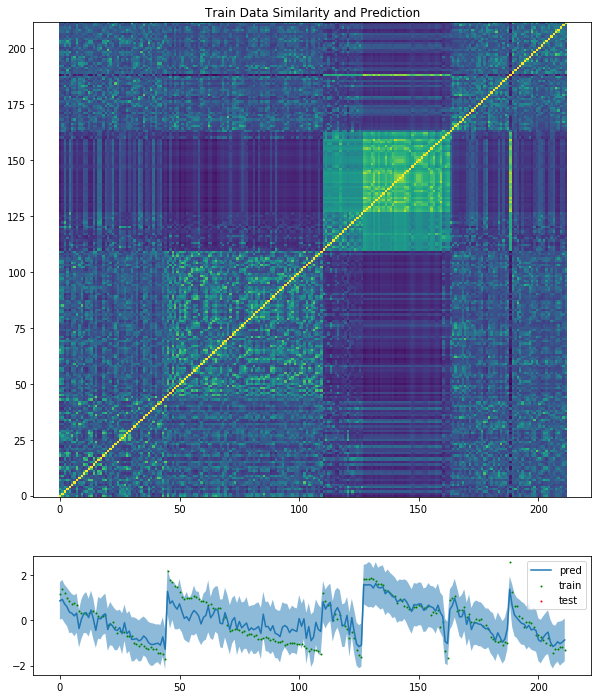

In [14]:
train_df = gpr_train_samples.train_df.drop_duplicates(subset = ['RBS']).reset_index()
test_df = gpr_train_samples.test_df.drop_duplicates(subset = ['RBS']).reset_index().drop(columns = ['level_0'])
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
generate_plot(train_df, 'Train Data Similarity and Prediction')

init kernel
groups:  ['bandit', 'bandit2', 'bps_core', 'bps_noncore', 'prob random', 'reference', 'uni random']
Group:  bandit
Number of sequences:  14
number of clusters:  4
Group:  bandit2
Number of sequences:  23
number of clusters:  6
Group:  bps_core
Number of sequences:  1
number of clusters:  1
Group:  bps_noncore
Number of sequences:  5
number of clusters:  2
Group:  prob random
Number of sequences:  3
number of clusters:  1
Group:  reference
Number of sequences:  1
number of clusters:  1
Group:  uni random
Number of sequences:  6
number of clusters:  2


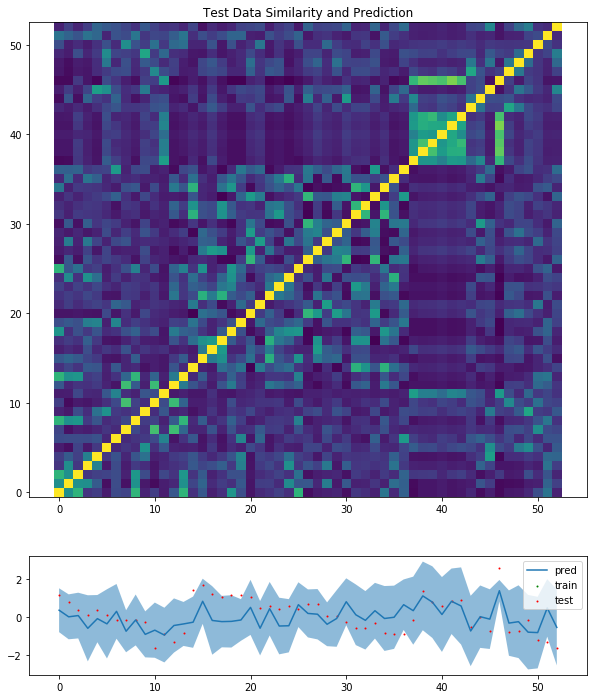

In [15]:
generate_plot(test_df, 'Test Data Similarity and Prediction')

In [16]:
train_test_df = pd.concat([train_df, test_df])
train_test_df = train_test_df.reset_index().drop(['level_0'], axis = 1)

train_test_df

,index,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std,...,Replicates,Plate,Round,Unnamed: 16,Rep7,Rep8,Rep9,Pred Mean,Pred Std,Pred UCB
0,0.0,CTTAAGAAGGAGATATACAT,AGGAGA,1.839138,0.268820,bps_noncore,Rep1,1.556251,1.588824,0.446031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,GTTAAGAAGGAGATATACAT,AGGAGA,0.646754,0.188587,bps_noncore,Rep1,0.603551,0.939087,0.446039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,ATTAAGAAGGAGATATACAT,AGGAGA,1.598899,0.220191,bps_noncore,Rep1,1.658359,1.451475,0.446046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,TCTAAGAAGGAGATATACAT,AGGAGA,1.812638,0.300722,bps_noncore,Rep1,1.545942,1.560777,0.467685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,TGTAAGAAGGAGATATACAT,AGGAGA,0.219540,0.139196,bps_noncore,Rep1,0.140540,0.604771,0.466792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,3293.0,TTTAAGATGGGGTTATACAT,TGGGGT,-0.242040,0.511032,bandit2,NaN,-0.242040,0.800985,0.626278,...,"4,5,6,7,8,9",Third_Plate,1.0,NaN,-0.010719,0.309109,0.266854,0.992797,0.510304,2.013404
261,1584.0,TTTAAGAGCGTGGTATACAT,GCGTGG,1.068670,0.021184,bandit2,NaN,1.068670,-0.240721,0.687405,...,"4,5,6,7,8,9",Third_Plate,1.0,NaN,0.977186,0.931848,0.981918,0.866603,0.741152,2.348908
262,NaN,TTTAAGAGTATGCTATACAT,GTATGC,-1.293337,0.420887,uni random,NaN,-1.293337,0.476886,0.768179,...,"1,2,3,4,5,6",First_Plate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,3323.0,TTTAAGATGGTGGTATACAT,TGGTGG,0.685176,0.204141,bandit2,NaN,0.685176,0.146944,0.673315,...,"4,5,6,7,8,9",Third_Plate,1.0,NaN,0.720600,0.726690,0.719150,0.871723,0.644897,2.161517


init kernel
groups:  ['bandit', 'bandit2', 'bps_core', 'bps_noncore', 'prob random', 'reference', 'uni random']
Group:  bandit
Number of sequences:  59
number of clusters:  15
Group:  bandit2
Number of sequences:  88
number of clusters:  23
Group:  bps_core
Number of sequences:  18
number of clusters:  5
Group:  bps_noncore
Number of sequences:  41
number of clusters:  11
Group:  prob random
Number of sequences:  28
number of clusters:  8
Group:  reference
Number of sequences:  2
number of clusters:  1
Group:  uni random
Number of sequences:  29
number of clusters:  8


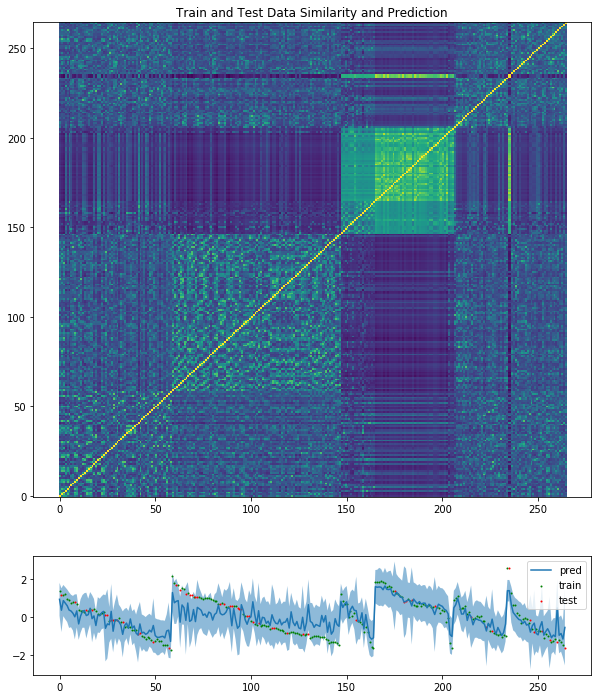

In [17]:
generate_plot(train_test_df, 'Train and Test Data Similarity and Prediction')